In [ ]:
%load core.py

/home/lachlan/.pyenv/versions/venv_readoutxfm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


script: /home/lachlan/CODEBASE/ReadoutXFM/config.py
script path: /home/lachlan/CODEBASE/ReadoutXFM
data path: /home/lachlan/CODEBASE/ReadoutXFM/data
---------------
opening .geo: geo2
---------------------------
EXTRACTING SPECTRA
---------------------------
stream length in bytes: 195154338
first two bytes: b'\xd4\x05'
header length: 1492
map dimensions x,y = 256,126
pixels expected: 32256
---------------------------
Row 0/126 at pixel 0, byte 1494 (0.0 %)
Row 1/126 at pixel 256, byte 1989406 (1.0 %)
Row 2/126 at pixel 512, byte 3951394 (2.0 %)
Row 3/126 at pixel 768, byte 5887362 (3.0 %)
Row 4/126 at pixel 1024, byte 7802358 (4.0 %)
Row 5/126 at pixel 1280, byte 9691478 (5.0 %)
Row 6/126 at pixel 1536, byte 11564662 (5.9 %)
Row 7/126 at pixel 1792, byte 13422850 (6.9 %)
Row 8/126 at pixel 2048, byte 15268250 (7.8 %)
Row 9/126 at pixel 2304, byte 17101210 (8.8 %)
Row 10/126 at pixel 2560, byte 18920754 (9.7 %)
Row 11/126 at pixel 2816, byte 20725602 (10.6 %)
Row 12/126 at pixel 3072, 

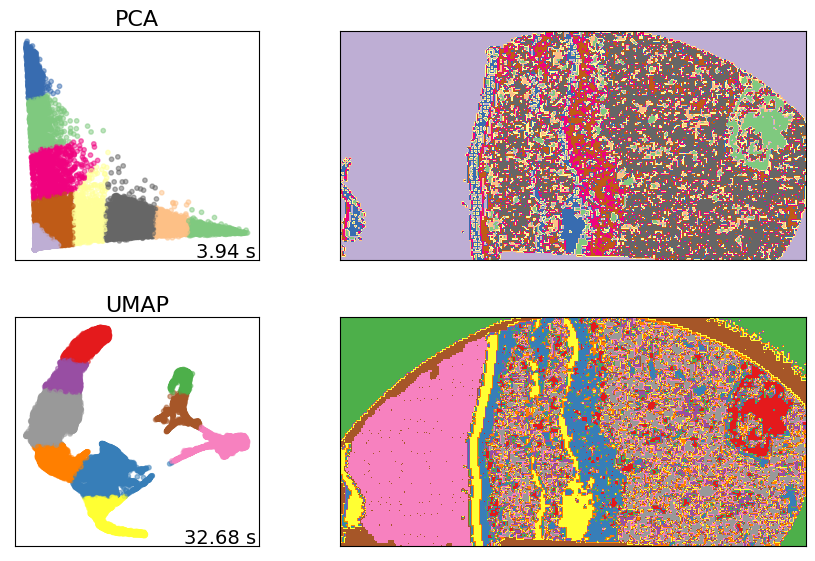

'\nsnip background\nhttps://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data\n'

In [1]:
# %load core.py
import os
import time
import gc
import time
import json

import numpy as np
from sklearn import decomposition
import umap.umap_ as umap

import config
import src.utils as utils
import src.bitops as bitops
import src.colour as colour
import src.clustering as clustering

"""
INITIALISE data TO WHOLE MAP EVEN IF USING EARLY STOP
.: huge memory req
can scale that down

also consider throwing away some, scaling down floats/ints etc

"""


"""
Parses spectrum-by-pixel maps from IXRF XFM

- parses binary .GeoPIXE files
- extracts pixel parameters
- projects spectra onto simple RGB channels
- displays as RGB

./data has example dataset

SPEED
                t/px
reading only:   0.00014 
colourmap:      0.0078
read and clust  0.001296 

"""

#-----------------------------------
#CLASSES
#-----------------------------------

#-----------------------------------
#INITIALISE
#-----------------------------------

starttime = time.time()             #init timer
chan=np.arange(0,config.NCHAN)      #channels
energy=chan*config.ESTEP            #energy list

#-----------------------------------
#MAIN START
#-----------------------------------

#check filetype is recognised - currently only accepts .GeoPIXE
if config.FTYPE == ".GeoPIXE":
    f = os.path.join(config.wdir,config.infile)
    fname = os.path.splitext(os.path.basename(f))[0]

    print("opening .geo:",fname)
else: 
    print(f'FATAL: filetype {config.FTYPE} not recognised')
    exit()

print(
    "---------------------------\n"
    "EXTRACTING SPECTRA\n"
    "---------------------------"
)

#open the datafile 
with open(f, mode='rb') as file: # rb = read binary
    
    #generate bytestream
    stream = file.read()         #NB. to read in chunks, add chunk size as read(SIZE)
    streamlen=len(stream)

    print(f"stream length in bytes: {streamlen}")
    print(f"first two bytes: {stream[:2]}")

    headerlen=bitops.binunpack(stream,0,"<H")[0]

    #check for header
    #   pixels start with "DP" (=20550 as <uint16)
    #   if we find this immediately, header is zero length
    #provided header is present
    #   read params from header
    if headerlen == 20550:
        print("WARNING: no header found")
        headerlen=0
        mapx=config.MAPX
        mapy=config.MAPY
        print("WARNING: map dimensions not found")
        print(f"-------using defaults {mapx},{mapy}")
    else:
        """
        if header present, read as json
        https://stackoverflow.com/questions/40059654/python-convert-a-bytes-array-into-json-format
        """
        #pull slice of byte stream corresponding to header
        #   bytes[0-2]= headerlen
        #   headerlen doesn't include trailing '\n' '}', so +2
        headerstream=stream[2:headerlen+2]
        #read it as utf8
        headerstream = headerstream.decode('utf8')
        
        #load into dictionary via json builtin
        headerdict = json.loads(headerstream)

        #create a human-readable dump for debugging
        headerdump = json.dumps(headerdict, indent=4, sort_keys=False)
        
        #get params
        mapx=headerdict['File Header']['Xres']  #map dimension x
        mapy=headerdict['File Header']['Yres']  #map dimension y

    #assign map size based on dimensions
    totalpx=mapx*mapy     

    #print run params
    print(f"header length: {headerlen}")
    print(f"map dimensions x,y = {mapx},{mapy}")

    #   if we are skipping some of the file
    #       assign the ratio and adjust totalpx
    if config.SHORTRUN:
        skipratio=config.shortpct/100
        trunc_y=int(np.ceil(mapy*skipratio))
        totalpx=mapx*trunc_y
        print(f"SHORT RUN: ending at {skipratio*100} %")

    print(f"pixels expected: {totalpx}")
    print("---------------------------")

    #assign starting pixel index 
    idx=headerlen+2 #legnth of header + 2 bytes

    #initialise pixel param arrays
    pxlen=np.zeros(totalpx,dtype=np.uint16)
    xidx=np.zeros(totalpx,dtype=np.uint16)
    yidx=np.zeros(totalpx,dtype=np.uint16)
    det=np.zeros(totalpx,dtype=np.uint8)
    dt=np.zeros(totalpx,dtype=np.uint16)
    
    if config.DOCOLOURS == True:
        #initalise pixel colour arrays
        rvals=np.zeros(totalpx)
        gvals=np.zeros(totalpx)
        bvals=np.zeros(totalpx)
        totalcounts=np.zeros(totalpx)

    #initialise data array
    data=np.zeros((totalpx,config.NCHAN),dtype=np.uint16)

    i=0 #pixel counter
    j=0 #row counter

    #loop through pixels
    while idx < streamlen:

        #print pixel index every row px
        if i % mapx == 0: 
            print(f"Row {j}/{mapy} at pixel {i}, byte {idx} ({100*idx/streamlen:.1f} %)")
            j+=1

        #read pixel record into spectrum and header param arrays, 
        # + reassign index at end of read
        outchan, counts, pxlen[i], xidx[i], yidx[i], det[i], dt[i], idx = bitops.readpxrecord(idx, stream)

        #fill gaps in spectrum 
        #   (ie. add 0s for all missing chans)
        outchan, counts = utils.gapfill(outchan,counts, config.NCHAN)

        #warn if recieved channel list is different length to chan array
        if len(outchan) != len(chan):
            print("WARNING: unexpected length of channel list")
      
        #assign counts into data array - 
        data[i,:]=counts

        #build colours if required
        if config.DOCOLOURS == True: rvals[i], bvals[i], gvals[i], totalcounts[i] = colour.spectorgb(energy, counts)
        
        #if pixel index greater than expected no. pixels based on map dimensions
        #   end if we are doing a truncated run
        #   else throw a warning
        if i >= (totalpx-1):
            if (config.SHORTRUN == True):   #i > totalpx is expected for short run
                print("ending at:", idx)
                idx=streamlen+1
                break 
            else:
                print(f"WARNING: pixel count {i} exceeds expected map size {totalpx}")
        i+=1

    runtime = time.time() - starttime

    print(
        "---------------------------\n"
        "MAP COMPLETE\n"
        "---------------------------\n"
        f"pixels expected (X*Y): {totalpx}\n"
        f"pixels found: {i}\n"
        f"total time: {round(runtime,2)} s\n"
        f"time per pixel: {round((runtime/i),6)} s\n"
        "---------------------------"
    )

    #clear the bytestream from memory
    del stream
    gc.collect()

    if config.DOCOLOURS == True:
        rgbarray=colour.clcomplete(rvals, gvals, bvals, totalcounts)
        colour.clshow(rgbarray)

    print("DOCLUST", config.DOCLUST)
    if config.DOCLUST:
        embedding, clusttimes = clustering.reduce(data)
        categories = clustering.dokmeans(embedding, totalpx)

        clustaverages=np.zeros([len(clustering.reducers),config.nclust,config.NCHAN])

        for i in range(len(clustering.reducers)):
            redname=clustering.getredname(i)
            clustaverages[i]=clustering.sumclusters(data, categories[i])
            
            for j in range(config.nclust):
                print(f'saving reducer {redname} cluster {j} with shape {clustaverages[i,j,:].shape}')
                np.savetxt(os.path.join(config.odir, "sum_" + redname + "_" + str(j) + ".txt"), np.c_[energy, clustaverages[i,j,:]], fmt=['%1.3e','%1.6e'])
            
            print(f'saving combined file for {redname}')
            np.savetxt(os.path.join(config.odir, "sum_" + redname + ".txt"), np.c_[energy, clustaverages[i,:,:].transpose(1,0)], fmt='%1.5e')             
            #plt.plot(energy, clustaverages[i,j,:])
        clustering.clustplt(embedding, categories, mapx, clusttimes)

    np.savetxt(os.path.join(config.odir, "pxlen.txt"), pxlen)
    np.savetxt(os.path.join(config.odir, "xidx.txt"), xidx)
    np.savetxt(os.path.join(config.odir, "yidx.txt"), yidx)
    np.savetxt(os.path.join(config.odir, "detector.txt"), det)
    np.savetxt(os.path.join(config.odir, "dt.txt"), dt)



"""
snip background
https://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data
"""

In [24]:
#import importlib
#importlib.reload(utils)

utils.varsizes(locals().items())

                          data: 252.0 MiB
                     embedding: 1008.1 KiB
                 clustaverages: 640.1 KiB
                    categories: 126.1 KiB
                         pxlen: 63.1 KiB
                          xidx: 63.1 KiB
                          yidx: 63.1 KiB
                            dt: 63.1 KiB
                          chan: 32.1 KiB
                        energy: 32.1 KiB


In [11]:
np.savetxt(os.path.join(config.odir,  "pxspec.dat"), data, fmt='%i')


In [15]:
rdata = np.loadtxt(os.path.join(config.odir, "pxspec.dat"), dtype=np.uint16)

print(data.shape)
print(rdata.shape)

(32256, 4096)
(32256, 4096)


In [25]:
print(rdata[200,50:100])
print(data[200,50:100])

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 0 1 2 1 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 0 1 2 1 1 0 0 0 0 0 0 0 0]


In [28]:
utils.varsizes(locals().items())

                          data: 252.0 MiB
                     embedding: 1008.1 KiB
                 clustaverages: 640.1 KiB
                    categories: 126.1 KiB
                         pxlen: 63.1 KiB
                          xidx: 63.1 KiB
                          yidx: 63.1 KiB
                            dt: 63.1 KiB
                          chan: 32.1 KiB
                        energy: 32.1 KiB


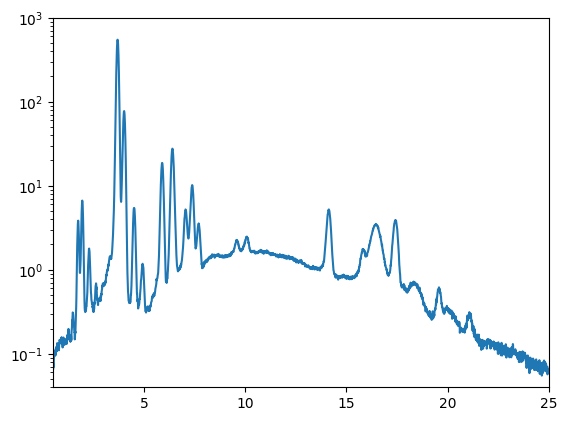

In [8]:
import matplotlib.pyplot as plt

workspec=clustaverages[1,4,:]

#plt.xscale("log")

plt.xlim(0.5,25)
plt.yscale("log")
plt.ylim(0.04,1000)
plt.plot(energy,workspec)




rgb maxima: r 0.5854687474777673 g 0.0924485809105398 b 1.0
scaled maxima: r 0.5854687474777673 g 0.0916801994152828 b 1.0


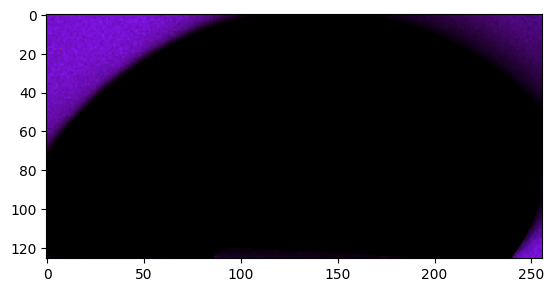

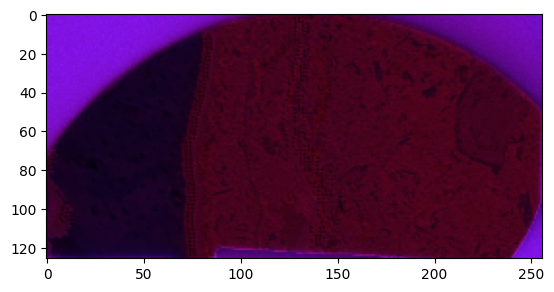

[0.46296169 0.4348753  0.43047089 ... 0.48756806 0.44075566 0.4654137 ]


In [44]:
"""
Baseline correction
"""
import pandas as pd
from scipy.signal import gaussian

#pybaselines project looks great
#https://pypi.org/project/pybaselines/

#alternately code from
#https://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data

def baseline_correction4(raman_spectra,lam,p,niter=10):
    #according to "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens
    number_of_spectra = raman_spectra.index.size

    #this is the code for the fitting procedure        
    L = len(raman_spectra.columns)
    w = np.ones(raman_spectra.shape[0]*raman_spectra.shape[1])

    D = sparse.block_diag(np.tile(sparse.diags([1,-2,1],[0,-1,-2],shape=(L,L-2)),number_of_spectra),format='csr')

    raman_spectra_flattened = raman_spectra.values.ravel()

    for jj in range(int(niter)):
        W = sparse.diags(w,format='csr')
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z,w*raman_spectra_flattened,permc_spec='NATURAL')
        w = p * (raman_spectra_flattened > z) + (1-p) * (raman_spectra_flattened < z)
    #end of fitting procedure

    baseline_data = pd.DataFrame(z.reshape(number_of_spectra,-1),index=raman_spectra.index,columns=raman_spectra.columns)
    return baseline_data

In [72]:
import struct 
import json

"""
https://stackoverflow.com/questions/40059654/python-convert-a-bytes-array-into-json-format
"""

headerstream=stream[2:headerlen+2]

headerstream = headerstream.decode('utf8')
"""
print(header[-100])
print("--------------------------")
print(jsonheader)
print("--------------------------")
#print(jsonheader[1300:1600])
#print("--------------------------")
print(jsonheader[1450:1480])
print(len(jsonheader))
"""

headerdict = json.loads(headerstream)
headerdump = json.dumps(headerdict, indent=4, sort_keys=False)

print(headerdump)
print("KEYS")
print(headerdict.keys())
nmapx=headerdict['File Header']['Xres']
nmapy=headerdict['File Header']['Yres']

print(nmapx,nmapy)



{
    "File Header": {
        "Timestamp": "7/14/2022 at 3:15 pm",
        "Duration (H:M:S)": "0:47:16",
        "Dwell (mS)": 75.0,
        "Xres": 256,
        "Yres": 126,
        "Width (mm)": 18.01,
        "Height (mm)": 8.86,
        "Dets": 2,
        "Chan": 4096,
        "Gain (eV)": 10.0,
        "Deadtime (%)": 0
    },
    "X-ray Source": {
        "KV": 50.0,
        "UA (\u00b5A)": 300.0,
        "Elt": "Mo",
        "Anode (\u00b5m)": 0.0,
        "WType": 1,
        "WThick (\u00b5m)": 125.0,
        "TType": 1,
        "TModel": 1,
        "OType": 2,
        "Spot (\u00b5m)": 10,
        "Filter": "None",
        "Incid (\u00b0)": 70.0,
        "Take (\u00b0)": 20.0,
        "Scat (\u00b0)": 140.0,
        "TTS (mm)": 125.0,
        "TTO (mm)": 0.0,
        "OLen (mm)": 0.0,
        "OTS (mm)": 0.0,
        "STD (mm)": 30.0
    },
    "Detector": {
        "Idx": 1,
        "Type": 5,
        "Elt": 14,
        "Area (mm\u00b2)": 150.0,
        "Coll (mm)": 3.1,
  

In [12]:
import json

print(f)


with open(f) as file: # rb = read binary
  
    # returns JSON object as 
    # a dictionary
    jsondata = json.load(file)
    
    # Iterating through the json
    # list
    for i in jsondata['emp_details']:
        print(i)
    
    # Closing file
    #f.close()

/home/lachlan/CODEBASE/ReadoutXFM/data/geo2.GeoPIXE


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd4 in position 0: invalid continuation byte